# Import required libraries

In [1]:
# Install keras_tuner
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [2]:
# Importing the required libraries
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Input, GRU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA

from datetime import date, timedelta
from google.colab import drive, files
import warnings
warnings.filterwarnings("ignore")
import itertools
import random
import os




# Load dataset

In [3]:
# Download latest version of dataset
file_path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")

print("Path to dataset files:", file_path)

100%|██████████| 11.9M/11.9M [00:00<00:00, 63.7MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/world-stock-prices-daily-updating/versions/340


In [4]:
# Filename of dataset
filename = "World-Stock-Prices-Dataset.csv"
file_path = os.path.join(file_path, filename)

In [5]:
# Load data with pandas
df = pd.read_csv(file_path)

# Exploratory Data Analysis

## Data preview

In [6]:
# First 5 rows of data
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-01 00:00:00-04:00,7.015000,7.070000,6.760000,6.850000,8781900.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-01 00:00:00-04:00,99.269997,100.099998,96.449997,96.650002,29508700.0,0.0,0.0,amd,AMD,technology,usa,NaN
2,2025-05-01 00:00:00-04:00,114.940002,117.760002,112.120003,114.699997,47000.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
3,2025-05-01 00:00:00-04:00,268.000000,272.660004,266.519989,268.540009,2473800.0,0.0,0.0,american express,AXP,finance,usa,NaN
4,2025-05-01 00:00:00-04:00,25.143000,25.143000,25.143000,25.143000,0.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN


In [7]:
# Last 5 rows of data
df.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
307250,2000-01-03 00:00:00-05:00,25.215814,25.330655,24.690826,24.772856,2173400.0,0.0,0.0,3m,MMM,manufacturing,usa,NaN
307251,2000-01-03 00:00:00-05:00,72.313085,72.405794,71.756831,72.034958,21200.0,0.0,0.0,toyota,TM,automotive,japan,NaN
307252,2000-01-03 00:00:00-05:00,7.289986,7.342182,7.098602,7.168196,882200.0,0.0,0.0,nordstrom,JWN,retail,usa,NaN
307253,2000-01-03 00:00:00-05:00,28.774989,28.808351,28.207830,28.608177,4275000.0,0.0,0.0,procter & gamble,PG,consumer goods,usa,NaN
307254,2000-01-03 00:00:00-05:00,5.731675,5.793975,5.427959,5.482471,5825700.0,0.0,0.0,american eagle outfitters,AEO,apparel,usa,NaN


In [8]:
# Reverse the order in dataset
df = df[::-1].reset_index(drop=True)

In [9]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2000-01-03 00:00:00-05:00,5.731675,5.793975,5.427959,5.482471,5825700.0,0.0,0.0,american eagle outfitters,AEO,apparel,usa,NaN
1,2000-01-03 00:00:00-05:00,28.774989,28.808351,28.207830,28.608177,4275000.0,0.0,0.0,procter & gamble,PG,consumer goods,usa,NaN
2,2000-01-03 00:00:00-05:00,7.289986,7.342182,7.098602,7.168196,882200.0,0.0,0.0,nordstrom,JWN,retail,usa,NaN
3,2000-01-03 00:00:00-05:00,72.313085,72.405794,71.756831,72.034958,21200.0,0.0,0.0,toyota,TM,automotive,japan,NaN
4,2000-01-03 00:00:00-05:00,25.215814,25.330655,24.690826,24.772856,2173400.0,0.0,0.0,3m,MMM,manufacturing,usa,NaN


In [10]:
df.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
307250,2025-05-01 00:00:00-04:00,25.143000,25.143000,25.143000,25.143000,0.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN
307251,2025-05-01 00:00:00-04:00,268.000000,272.660004,266.519989,268.540009,2473800.0,0.0,0.0,american express,AXP,finance,usa,NaN
307252,2025-05-01 00:00:00-04:00,114.940002,117.760002,112.120003,114.699997,47000.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
307253,2025-05-01 00:00:00-04:00,99.269997,100.099998,96.449997,96.650002,29508700.0,0.0,0.0,amd,AMD,technology,usa,NaN
307254,2025-05-01 00:00:00-04:00,7.015000,7.070000,6.760000,6.850000,8781900.0,0.0,0.0,peloton,PTON,fitness,usa,NaN


In [11]:
# Info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307255 entries, 0 to 307254
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           307255 non-null  object 
 1   Open           307255 non-null  float64
 2   High           307255 non-null  float64
 3   Low            307255 non-null  float64
 4   Close          307255 non-null  float64
 5   Volume         307255 non-null  float64
 6   Dividends      307255 non-null  float64
 7   Stock Splits   307255 non-null  float64
 8   Brand_Name     307255 non-null  object 
 9   Ticker         307255 non-null  object 
 10  Industry_Tag   307255 non-null  object 
 11  Country        307255 non-null  object 
 12  Capital Gains  2 non-null       float64
dtypes: float64(8), object(5)
memory usage: 30.5+ MB


In [12]:
# Number of stocks with no duplication
print("Number of stocks:", len(df['Ticker'].unique()))

Number of stocks: 61


In [13]:
# Number of null values in each column
print(df.isnull().sum())

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
Brand_Name            0
Ticker                0
Industry_Tag          0
Country               0
Capital Gains    307253
dtype: int64


In [14]:
# Select a Specific Stock
selected_stock = "AAPL"  # Change ticker if needed
df_stock = df[df["Ticker"] == selected_stock].sort_values(by="Date").reset_index(drop=True)

In [15]:
# Change date to datetime and set the date as index
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_chg= df_stock.set_index(['Date'], drop=True)
df_chg.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
Date,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,0.794800,0.852586,0.770643,0.848323,535796800.0,0.0,0.0,apple,AAPL,technology,usa,NaN
2000-01-04 00:00:00-05:00,0.820377,0.838376,0.766854,0.776801,512377600.0,0.0,0.0,apple,AAPL,technology,usa,NaN
2000-01-05 00:00:00-05:00,0.786273,0.837902,0.780590,0.788168,778321600.0,0.0,0.0,apple,AAPL,technology,usa,NaN
2000-01-06 00:00:00-05:00,0.804273,0.810904,0.719961,0.719961,767972800.0,0.0,0.0,apple,AAPL,technology,usa,NaN
2000-01-07 00:00:00-05:00,0.731329,0.765433,0.723751,0.754065,460734400.0,0.0,0.0,apple,AAPL,technology,usa,NaN


## Moving average

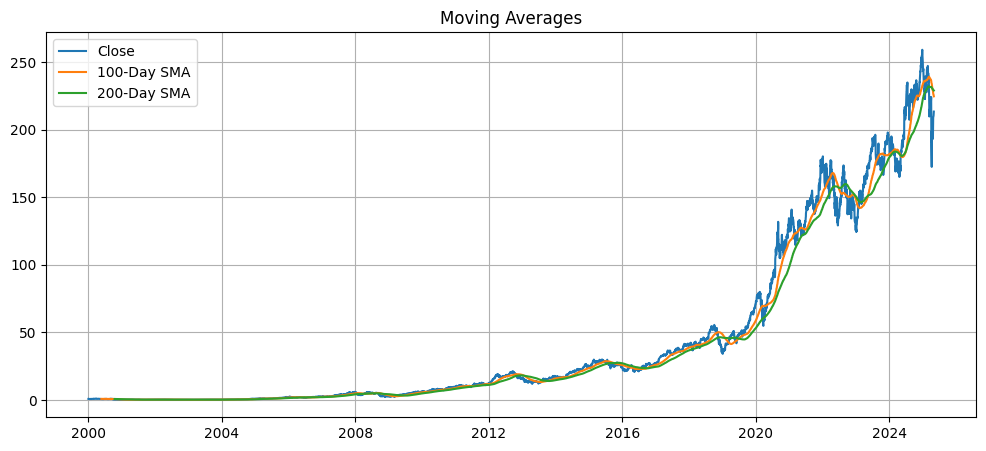

In [16]:
# Plot the moving average graph
df_chg['SMA_100'] = df_chg['Close'].rolling(window=100).mean()
df_chg['SMA_200'] = df_chg['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_chg['Close'], label='Close')
plt.plot(df_chg['SMA_100'], label='100-Day SMA')
plt.plot(df_chg['SMA_200'], label='200-Day SMA')
plt.title('Moving Averages')
plt.legend()
plt.grid(True)
plt.show()


## Daily Return

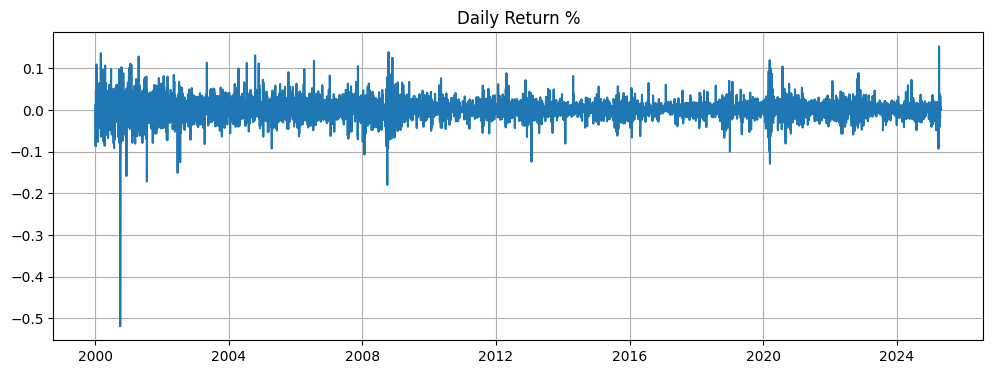

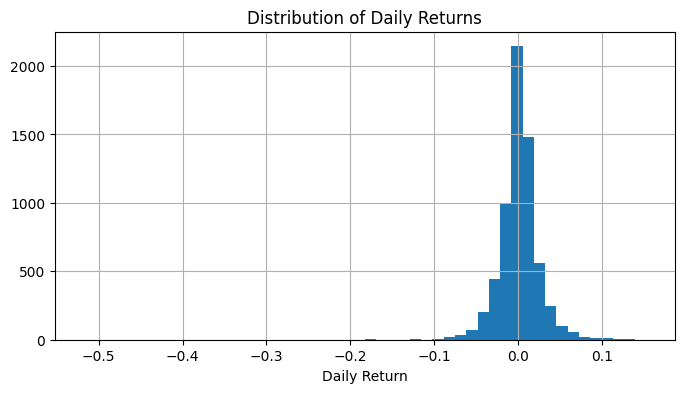

In [17]:
# Plot the percentage of daily return of stock
df_chg['Daily Return'] = df_chg['Close'].pct_change()

plt.figure(figsize=(12, 4))
plt.plot(df_chg['Daily Return'])
plt.title('Daily Return %')
plt.grid(True)
plt.show()

# Histogram
df_chg['Daily Return'].hist(bins=50, figsize=(8, 4))
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.show()


## Correlation Heatmap

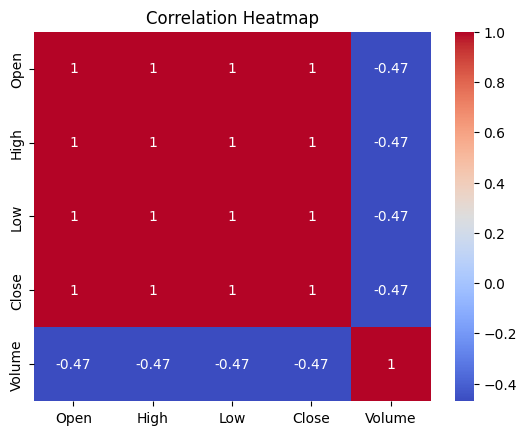

In [18]:
import seaborn as sns

sns.heatmap(df_chg[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Summary of data

In [19]:
# Summary Statistics
print("\n📌 Basic Statistics of Stock Prices:")
print(df_chg.describe())


📌 Basic Statistics of Stock Prices:
              Open         High          Low        Close        Volume  \
count  6421.000000  6421.000000  6421.000000  6421.000000  6.421000e+03   
mean     45.237450    45.732498    44.774311    45.277400  3.791551e+08   
std      65.241024    65.958820    64.591945    65.317223  3.826502e+08   
min       0.196890     0.199922     0.192798     0.198861  2.096501e+07   
25%       2.090162     2.119263     2.046812     2.081674  1.104816e+08   
50%      15.248210    15.365095    15.083007    15.229196  2.591400e+08   
75%      48.155030    48.651599    47.883435    48.283989  5.083484e+08   
max     258.190002   260.100006   257.630005   259.019989  7.421641e+09   

         Dividends  Stock Splits  Capital Gains      SMA_100      SMA_200  \
count  6421.000000   6421.000000            0.0  6322.000000  6222.000000   
mean      0.001361      0.002336            NaN    44.279214    43.094010   
std       0.015975      0.106608            NaN    63.69

# Data Preprocessing

## Feature engineering

In [20]:
# Drop all columns except for 'Date' and 'Close' column
df_chg.drop(['Open',	'High',	'Low', 'Volume',	'Brand_Name',	'Ticker',	'Industry_Tag',	'Country',	'Dividends',	'Stock Splits',	'Capital Gains', 'SMA_100',	'SMA_200',	'Daily Return'], axis=1, inplace=True)
df_chg.head(10)

,Close
Date,
2000-01-03 00:00:00-05:00,0.848323
2000-01-04 00:00:00-05:00,0.776801
2000-01-05 00:00:00-05:00,0.788168
2000-01-06 00:00:00-05:00,0.719961
2000-01-07 00:00:00-05:00,0.754065
2000-01-10 00:00:00-05:00,0.740802
2000-01-11 00:00:00-05:00,0.702910
2000-01-12 00:00:00-05:00,0.660754
2000-01-13 00:00:00-05:00,0.733224


In [21]:
# Ensure the columns are dropped
df_chg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6421 entries, 2000-01-03 00:00:00-05:00 to 2025-05-01 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6421 non-null   float64
dtypes: float64(1)
memory usage: 358.4+ KB


In [22]:
df_chg.head(5)

,Close
Date,
2000-01-03 00:00:00-05:00,0.848323
2000-01-04 00:00:00-05:00,0.776801
2000-01-05 00:00:00-05:00,0.788168
2000-01-06 00:00:00-05:00,0.719961
2000-01-07 00:00:00-05:00,0.754065


In [23]:
df_chg.tail(5)

,Close
Date,
2025-04-25 00:00:00-04:00,209.279999
2025-04-28 00:00:00-04:00,210.139999
2025-04-29 00:00:00-04:00,211.210007
2025-04-30 00:00:00-04:00,212.500000
2025-05-01 00:00:00-04:00,213.320007


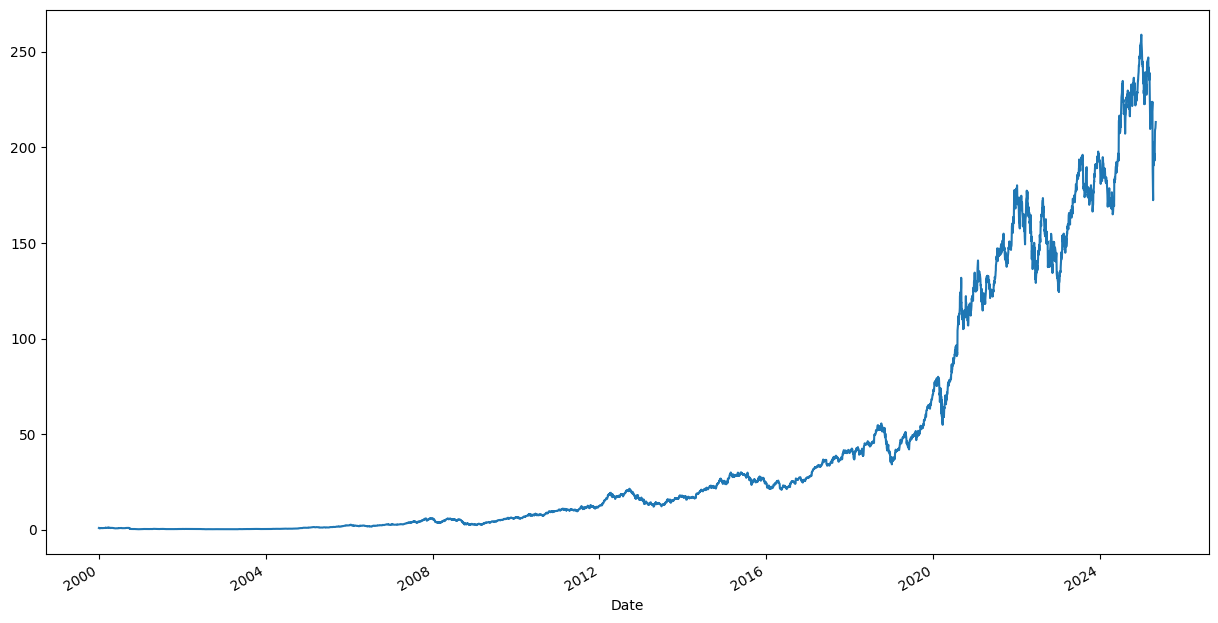

In [24]:
#Plot the close price plot
plt.figure(figsize=(15,8))
df_chg['Close'].plot();

## Normalization (Using MinMaxScaler)

In [25]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_chg)

In [26]:
# Display the first 5 scaled values
print(scaled_data[:5])

[[0.00250931]
 [0.00223297]
 [0.00227689]
 [0.00201336]
 [0.00214513]]


## Split training and testing data

In [27]:
# Create a function to convert data into sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

# Use 60 time steps to predict the next value
time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

In [28]:
# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [29]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(5088, 60, 1)
(1273, 60, 1)
(5088,)
(1273,)


# Define LSTM model

In [30]:
# Initialize the Sequential model
model = Sequential()

# Define the input layer
model.add(Input(shape=(time_steps, 1)))

# Add the LSTM layer
model.add(LSTM(50, return_sequences=False))

# Normalizes layer outputs to stabilize and speed up training
model.add(BatchNormalization())

# Dropout to regularize the LSTM
model.add(Dropout(0.2))

# Add a Dense layer for output
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Training data

In [ ]:
# Define EarlyStopping Callback
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks = es, verbose = 1)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0167 - root_mean_squared_error: 0.1273 - val_loss: 0.2451 - val_root_mean_squared_error: 0.4951
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.2392 - val_root_mean_squared_error: 0.4891
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 8.3280e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.1210 - val_root_mean_squared_error: 0.3479
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 4.0104e-04 - root_mean_squared_error: 0.0200 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.3926e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0675
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 2.8777e-04 - root_mean_squared_error: 0.0169 - val_loss: 7.2755e-04 - val_root_mean_squared_error: 0.0270
Epoch 7/50
159/159 ━━━━━

In [ ]:
# List the names of the metrics and losses that were recorded
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

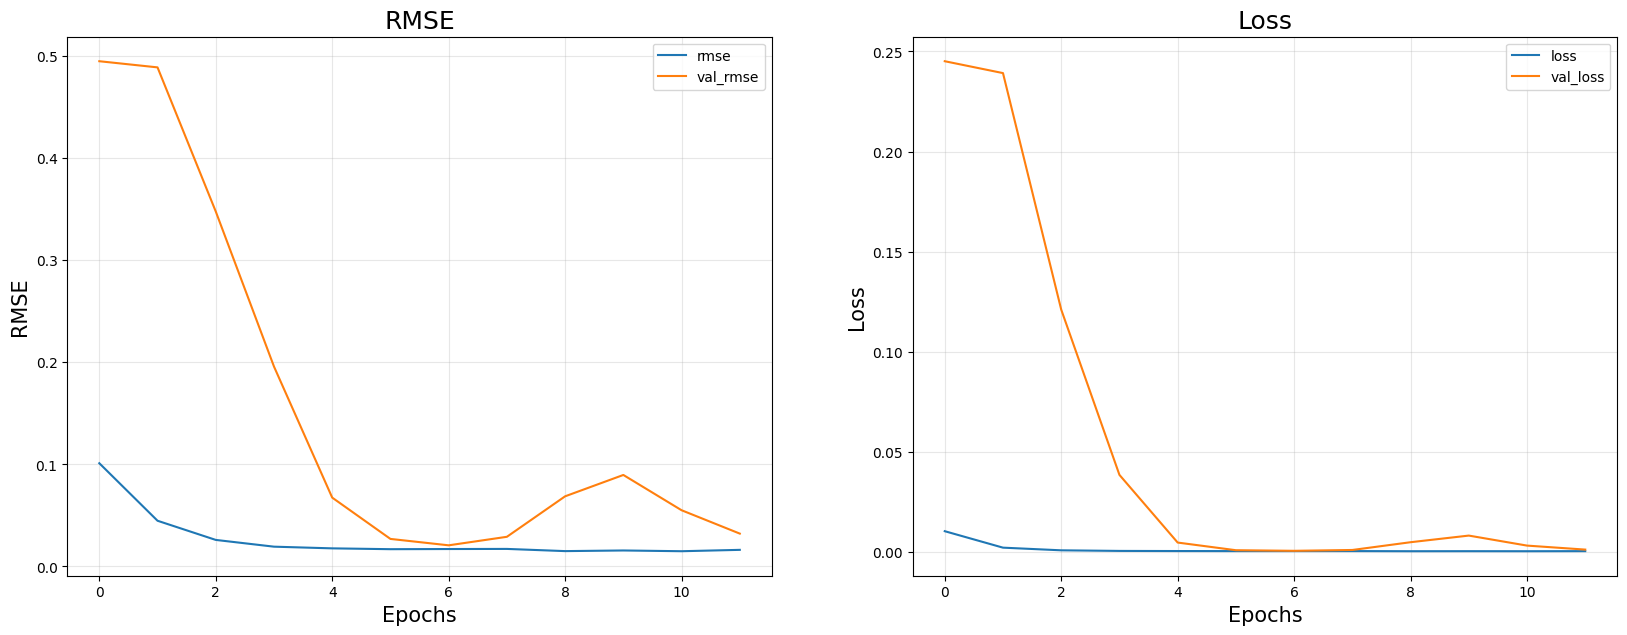

In [ ]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy curve (RMSE)
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Loss Curve
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

# Hyperparameter tuning

In [ ]:
# Define tuning model for LSTM
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(time_steps, 1)))

    # LSTM Units (choose between 32 to 128 in steps of 16)
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=16),
                   return_sequences=False))

    # Dropout rate
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # BatchNormalization
    model.add(BatchNormalization())

    # Dense Output
    model.add(Dense(1))

    # Learning Rate
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
# Define the function for searching best parameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_root_mean_squared_error',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_stock_tuning'
)

Reloading Tuner from tuner_dir/lstm_stock_tuning/tuner0.json


In [ ]:
# Search for best parameters
tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=20,
             callbacks=[EarlyStopping(patience=3)],
             verbose=1)

In [ ]:
# List the best parameters
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,449 (17.38 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Train using best parameters
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    callbacks=[EarlyStopping(patience=5)],
                    verbose=1)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0145 - root_mean_squared_error: 0.1178 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 6.4144e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.8342e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.3665e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.1749e-04 - root_mean_squared_error: 0.0108 - val_loss: 7.1298e-04 - val_root_mean_squared_error: 0.0267
Epoch 7/100
127/12

In [ ]:
# Download the best model
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

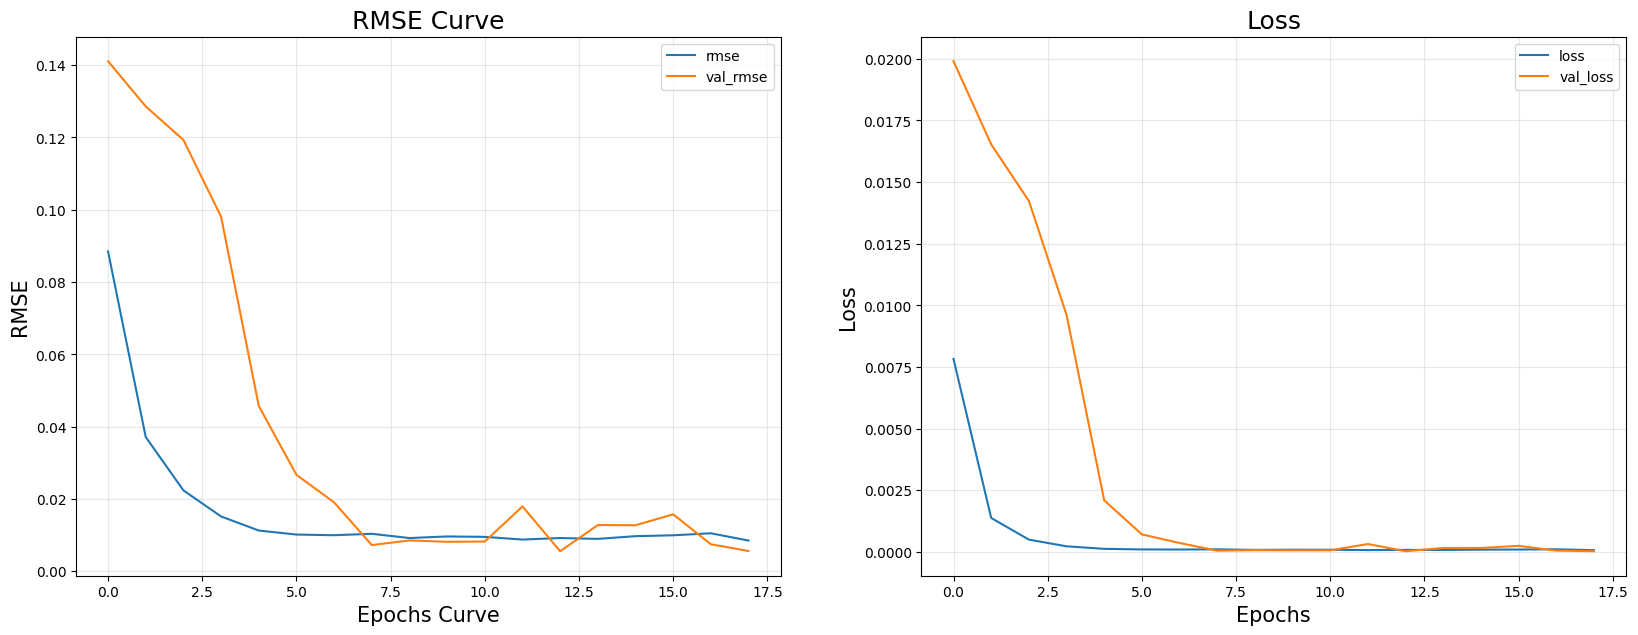

In [ ]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy curve
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE Curve", fontsize=18)
plt.xlabel("Epochs Curve", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Loss Curve
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

# Testing data

In [31]:
# Load the best model
uploaded = files.upload()  # Select best_model_colab.h5 from computer
model = load_model('best_model.h5', compile=False)

Saving best_model_colab.h5 to best_model_colab.h5


In [32]:
# Save model locally
model.save("best_model.h5")

In [33]:
# Make predictions on the test data
y_pred = model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [34]:
# Inverse transform the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [35]:
# Evaluation Metrics
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2_lstm = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"📉 MSE:  {mse_lstm:.4f}")
print(f"📉 RMSE: {rmse_lstm:.4f}")
print(f"📊 MAE:  {mae_lstm:.4f}")
print(f"📈 R² Score: {r2_lstm:.4f}")

📉 MSE:  55.8039
📉 RMSE: 7.4702
📊 MAE:  6.0508
📈 R² Score: 0.9627


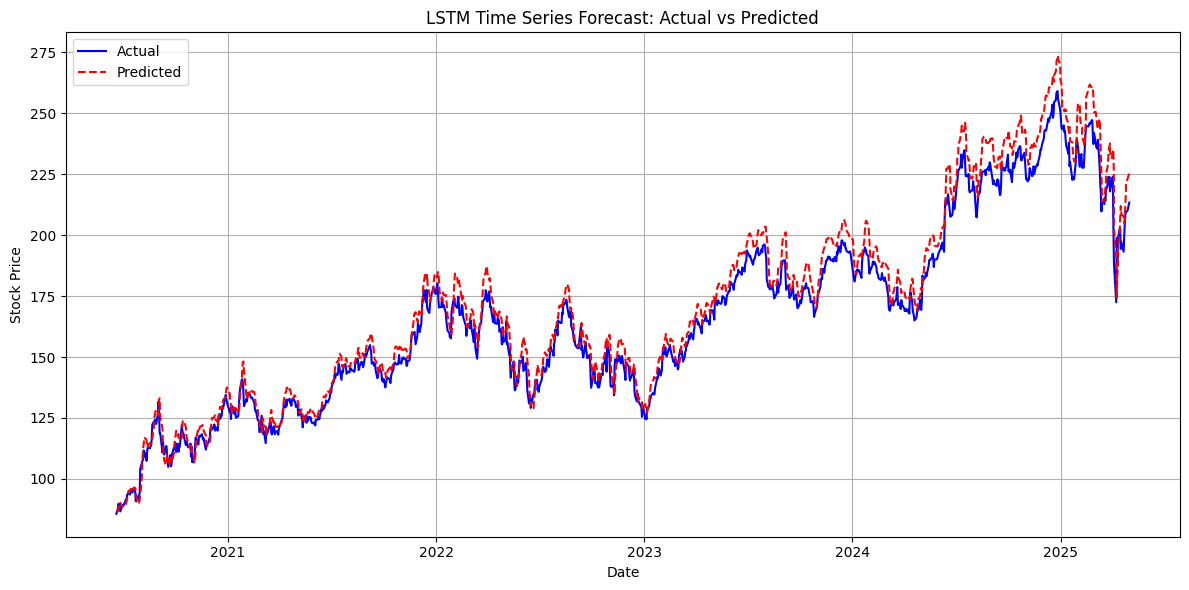

In [36]:
# Plot the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(df_chg.index[-len(y_test_rescaled):], y_test_rescaled, label='Actual', color='blue')
plt.plot(df_chg.index[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted', color='red', linestyle='dashed')
plt.title('LSTM Time Series Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecast future data

In [37]:
# Define Parameters
n_future_days = 30  # How many days to forecast
recent_sequence = X_test[-1]  # shape: (time_steps, 1)

In [38]:
# Start recursive prediction
future_predictions = []

In [39]:
# Reshape for prediction
current_input = recent_sequence.reshape(1, time_steps, 1)

In [40]:
# Start prediction
for _ in range(n_future_days):
    pred = model.predict(current_input)[0][0]  # shape: (1,) → scalar

    future_predictions.append(pred)

    # Update input: drop oldest, add latest prediction
    current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [41]:
# Inverse scale predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

In [42]:
# Create future dates for x-axis
last_date = last_date = pd.Timestamp.today().normalize()  # Use current date
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_future_days, freq='B')

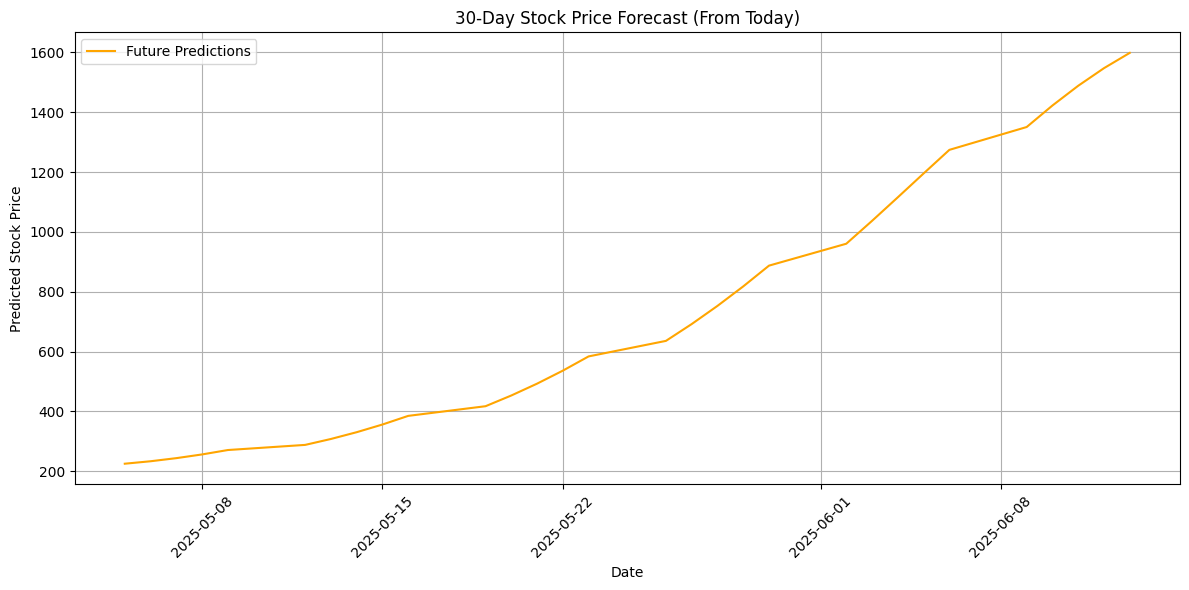

In [43]:
# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions', color='orange')
plt.title(f'{n_future_days}-Day Stock Price Forecast (From Today)')
plt.xlabel('Date')
plt.ylabel('Predicted Stock Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Benchmarks

In [44]:
# Reshape data for Random Forest and SVR
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

y_train_rf = y_train.ravel()
y_test_rf = y_test.ravel()

## ARIMA

In [45]:
# Fit ARIMA once on the entire training set
model_arima = ARIMA(y_train, order=(5,1,0)).fit()

In [46]:
# Forecast the entire test set in one go
predictions_arima = model_arima.forecast(steps=len(y_test))

In [47]:
rmse_arima = np.sqrt(mean_squared_error(y_test, predictions_arima))

In [48]:
# Calculate predictions error metrics
mse_arima = mean_squared_error(y_test, predictions_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_test, predictions_arima)
r2_arima = r2_score(y_test, predictions_arima)

In [49]:
# Display results
print(f"📉 ARIMA MSE:  {mse_arima:.4f}")
print(f"📉 ARIMA RMSE: {rmse_arima:.4f}")
print(f"📊 ARIMA MAE:  {mae_arima:.4f}")
print(f"📈 ARIMA R² Score: {r2_arima:.4f}")

📉 ARIMA MSE:  0.1213
📉 ARIMA RMSE: 0.3483
📊 ARIMA MAE:  0.3146
📈 ARIMA R² Score: -4.4246


## Recurrent Neural Network (RNN)

In [50]:
# Basic RNN benchmark
rnn = Sequential()
rnn.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
rnn.add(Dense(1))
rnn.compile(optimizer='adam', loss='mse')

In [51]:
rnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

In [52]:
predictions_rnn = rnn.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [53]:
# Evaluation metrics
mse_rnn = mean_squared_error(y_test, predictions_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_test, predictions_rnn)
r2_rnn = r2_score(y_test, predictions_rnn)

In [54]:
# Print results
print(f"📉 RNN MSE:  {mse_rnn:.4f}")
print(f"📉 RNN RMSE: {rmse_rnn:.4f}")
print(f"📊 RNN MAE:  {mae_rnn:.4f}")
print(f"📈 RNN R² Score: {r2_rnn:.4f}")

📉 RNN MSE:  0.0012
📉 RNN RMSE: 0.0348
📊 RNN MAE:  0.0291
📈 RNN R² Score: 0.9460


## Random Forest

In [55]:
# Random Forest benchmark
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(random_state=42)

In [56]:
predictions_rf = rf.predict(X_test_rf)

In [57]:
# Compute metrics
mse_rf = mean_squared_error(y_test_rf, predictions_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_rf, predictions_rf)
r2_rf = r2_score(y_test_rf, predictions_rf)

In [58]:
# Print results
print(f"📉 Random Forest MSE:  {mse_rf:.4f}")
print(f"📉 Random Forest RMSE: {rmse_rf:.4f}")
print(f"📊 Random Forest MAE:  {mae_rf:.4f}")
print(f"📈 Random Forest R² Score: {r2_rf:.4f}")

📉 Random Forest MSE:  0.1239
📉 Random Forest RMSE: 0.3520
📊 Random Forest MAE:  0.3187
📈 Random Forest R² Score: -4.5414


## Support Vector Regression (SVR)

In [59]:
# SVR benchmark
svr = SVR(kernel='rbf')
svr.fit(X_train_rf, y_train_rf)

SVR()

In [60]:
predictions_svr = svr.predict(X_test_rf)

In [61]:
# Compute metrics
mse_svr = mean_squared_error(y_test_rf, predictions_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test_rf, predictions_svr)
r2_svr = r2_score(y_test_rf, predictions_svr)

In [62]:
# Print results
print(f"📉 SVR MSE:  {mse_svr:.4f}")
print(f"📉 SVR RMSE: {rmse_svr:.4f}")
print(f"📊 SVR MAE:  {mae_svr:.4f}")
print(f"📈 SVR R² Score: {r2_svr:.4f}")

📉 SVR MSE:  0.2529
📉 SVR RMSE: 0.5029
📊 SVR MAE:  0.4792
📈 SVR R² Score: -10.3082


## Comparison between models

In [63]:
# Prepare the data
metrics_data = {
    'Model': ['ARIMA', 'RNN', 'Random Forest', 'SVR'],
    'MSE': [mse_arima, mse_rnn, mse_rf, mse_svr],
    'RMSE': [rmse_arima, rmse_rnn,rmse_rf, rmse_svr],
    'MAE': [mae_arima, mae_rnn, mae_rf, mae_svr],
    'R² Score': [r2_arima, r2_rnn, r2_rf, r2_svr]
}

In [64]:
# Create DataFrame
comparison_df = pd.DataFrame(metrics_data)

In [65]:
# Display
print("📊 Model Performance Comparison:")
print(comparison_df)

📊 Model Performance Comparison:
           Model       MSE      RMSE       MAE   R² Score
0          ARIMA  0.121306  0.348289  0.314557  -4.424559
1            RNN  0.001208  0.034752  0.029105   0.945995
2  Random Forest  0.123918  0.352020  0.318675  -4.541389
3            SVR  0.252878  0.502869  0.479201 -10.308223


# Dashboard (Streamlit)

In [66]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [67]:
from pyngrok import ngrok
ngrok.set_auth_token("2w91e3AJxVksJwxR6iGjEQsyhze_4nNmpSW4YNxugs29u3DgH")

In [68]:
%%writefile app.py
import streamlit as st
import kagglehub
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# --- Load dataset from KaggleHub ---
file_path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")
filename = "World-Stock-Prices-Dataset.csv"
file_path = os.path.join(file_path, filename)

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

# --- Sidebar: Stock selection & number of future days ---
st.sidebar.title("📈 Stock Prediction Settings")
available_stocks = sorted(df['Brand_Name'].unique())
selected_stock = st.sidebar.selectbox("Choose a Stock", available_stocks)
n_future_days = st.sidebar.slider("Days to Predict", min_value=30, max_value=100, value=7)

# --- Filter and prepare data ---
stock_data = df[df['Brand_Name'] == selected_stock].copy()
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None)
stock_data = stock_data.sort_values("Date")

# --- Let user pick historical date range ---
st.sidebar.markdown("### 🔍 View Historical Data")
min_date = stock_data['Date'].min().date()
max_date = stock_data['Date'].max().date()

start_hist = st.sidebar.date_input("From", value=min_date, min_value=min_date, max_value=max_date)
end_hist = st.sidebar.date_input("To", value=max_date, min_value=min_date, max_value=max_date)

# --- Filter historical range ---
historical_view = stock_data[(stock_data['Date'].dt.date >= start_hist) & (stock_data['Date'].dt.date <= end_hist)]

# --- Prepare Close price ---
close_prices = stock_data['Close'].values.reshape(-1, 1)

# --- Scaling ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# --- Create sequence (recent input for forecasting) ---
n_past = 90  # Number of past days used
time_steps = n_past
recent_sequence = scaled_data[-time_steps:]  # last 60 days

current_input = recent_sequence.reshape(1, time_steps, 1)

# --- Load the best model ---
model = load_model('best_model.h5', compile=False)

# --- Start Recursive Forecasting ---
future_predictions = []

for _ in range(n_future_days):
    pred = model.predict(current_input)[0][0]  # Get the scalar prediction

    future_predictions.append(pred)

    # Update input by dropping oldest and appending latest prediction
    current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

# --- Inverse scale the predictions ---
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_rescaled = scaler.inverse_transform(future_predictions).flatten()

# --- Generate Future Dates ---
last_date = pd.Timestamp.today().normalize()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_future_days, freq='B')

# --- Plot Historical Graph ---
st.title("📊 Historical Stock Prices")
st.subheader(f"{selected_stock} from {start_hist} to {end_hist}")

fig_hist, ax_hist = plt.subplots(figsize=(12, 5))
ax_hist.plot(historical_view['Date'], historical_view['Close'], color='blue', label='Historical Close Price')
ax_hist.set_title(f"{selected_stock} Historical Prices")
ax_hist.set_xlabel("Date")
ax_hist.set_ylabel("Close Price")
ax_hist.grid(True)
ax_hist.legend()
plt.xticks(rotation=45)
st.pyplot(fig_hist)

# Allow CSV download
csv_hist = historical_view.to_csv(index=False)
st.download_button(
    label="📥 Download Historical Data as CSV",
    data=csv_hist,
    file_name=f"{selected_stock}_historical_{start_hist}_to_{end_hist}.csv",
    mime='text/csv'
)

# --- Plot Forecast ---
st.title("📈 Future Stock Price Forecast")
st.subheader(f"Stock: {selected_stock} | Days to Forecast: {n_future_days}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(future_dates, future_predictions_rescaled, label='Future Predictions', color='red')

ax.set_title(f'{n_future_days}-Day Stock Price Forecast (Starting from Today)')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted Close Price')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

st.pyplot(fig)

# Optionally Show Predicted Values
if st.checkbox("Show Predicted Values as Table (Recommended)"):
    pred_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Close Price': future_predictions_rescaled
    })
    st.dataframe(pred_df)

Writing app.py


In [69]:
# Create a public URL for the Streamlit app
public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)


🌍 Public URL: NgrokTunnel: "https://f41d-35-221-16-188.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Run the Streamlit app in the background
!pkill -f streamlit
!streamlit run app.py &>/content/log.txt